# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__13 марта 01:00__</span>.

Мягкий дедлайн: <span style="color:red">__27 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import os
import pathlib

import cv2
from PIL import Image
from typing import Tuple, Union, List, Callable, Optional

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import cv2 as cv

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms: Optional[List[Callable]] = None, image_ext: str = 'jpg', target_ext: str = 'png'):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = pathlib.Path(images_dir) if isinstance(images_dir, str) else images_dir
        self.target_dir = pathlib.Path(target_dir) if isinstance(target_dir, str) else target_dir
        self.transforms = transforms
        
        self.image_ext = image_ext
        self.target_ext = target_ext
        
        self.objects_names = self._lookup_dirs()
        
    def _lookup_dirs(self) -> List[str]:
        object_names = [p.stem for p in self.images_dir.glob(f'*.{self.image_ext}')]
        
        return object_names
        
    def __len__(self):
        return len(self.objects_names)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        objects_name = self.objects_names[idx]
        img_path = self.images_dir.joinpath(f"{objects_name}.{self.image_ext}")
        mask_path = self.target_dir.joinpath(f"{objects_name}.{self.target_ext}")
        
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        
        if self.transforms is not None:
            for transform in self.transforms:
                img = transform(img)
                mask = transform(mask)
        
        return img, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

In [3]:
from torchvision import transforms

In [4]:
class RandomFlip(object):
    def __init__(self, p: float):
        if not isinstance(p, float):
            raise TypeError(f'p must be float, not {type(p)=}')
        if not (0.0 <= p <= 1.0):
            raise ValueError(f'p must be in [0.0, 1.0], {p=:.4f}')
        
        self.p = p
    
    def __call__(self, img, target):
        rs = (np.random.rand(1) < self.p)[0]
        
        if rs:
            return transforms.functional.hflip(img), transforms.functional.hflip(target)
        return img, target

class RandomCrop(object):
    def __init__(self, p: float, size: tuple[float, float]):      
        self.p = p
        self.size = size
    
    def __call__(self, img, target):
        rs = (np.random.rand(1) < self.p)[0]
        
        top = np.random.randint(img.shape[1] - self.size[1])
        left = np.random.randint(img.shape[0] - self.size[0])
        
        height = self.size[1]
        width = self.size[0]
        
        if rs:
            return (
                transforms.functional.resized_crop(
                    img,
                    top, left, height, width,
                    size=img.shape,
                ), 
                transforms.functional.hflip(
                    target,
                    top, left, height, width,
                    size=target.shape,
                )
            )
        
        return img, target

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [5]:
DATA_PATH = pathlib.Path('people_data')

train_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('train'),
    target_dir=DATA_PATH.joinpath('train_mask'),
    transforms=[transforms.ToTensor()]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('test'),
    target_dir=DATA_PATH.joinpath('test_mask'),
    transforms=[transforms.ToTensor()]
)

Функция для отображения изображения:

In [6]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

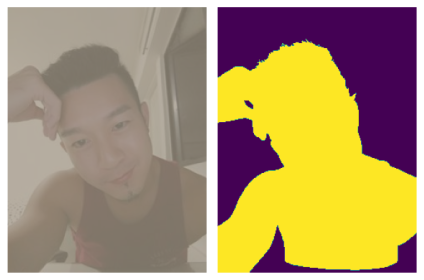

In [7]:
show_idx_image(train_dataset, 159)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [8]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=6)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=6, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [9]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = 1 - 2 * torch.sum(true_labels * logits, dim=[1, 2]) / torch.sum(true_labels + logits + self.eps, dim=[1, 2])
        if self.reduction == 'mean':
            loss_value = torch.mean(loss_value)
        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value)
        
        return loss_value

Проверка реализации:

In [10]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

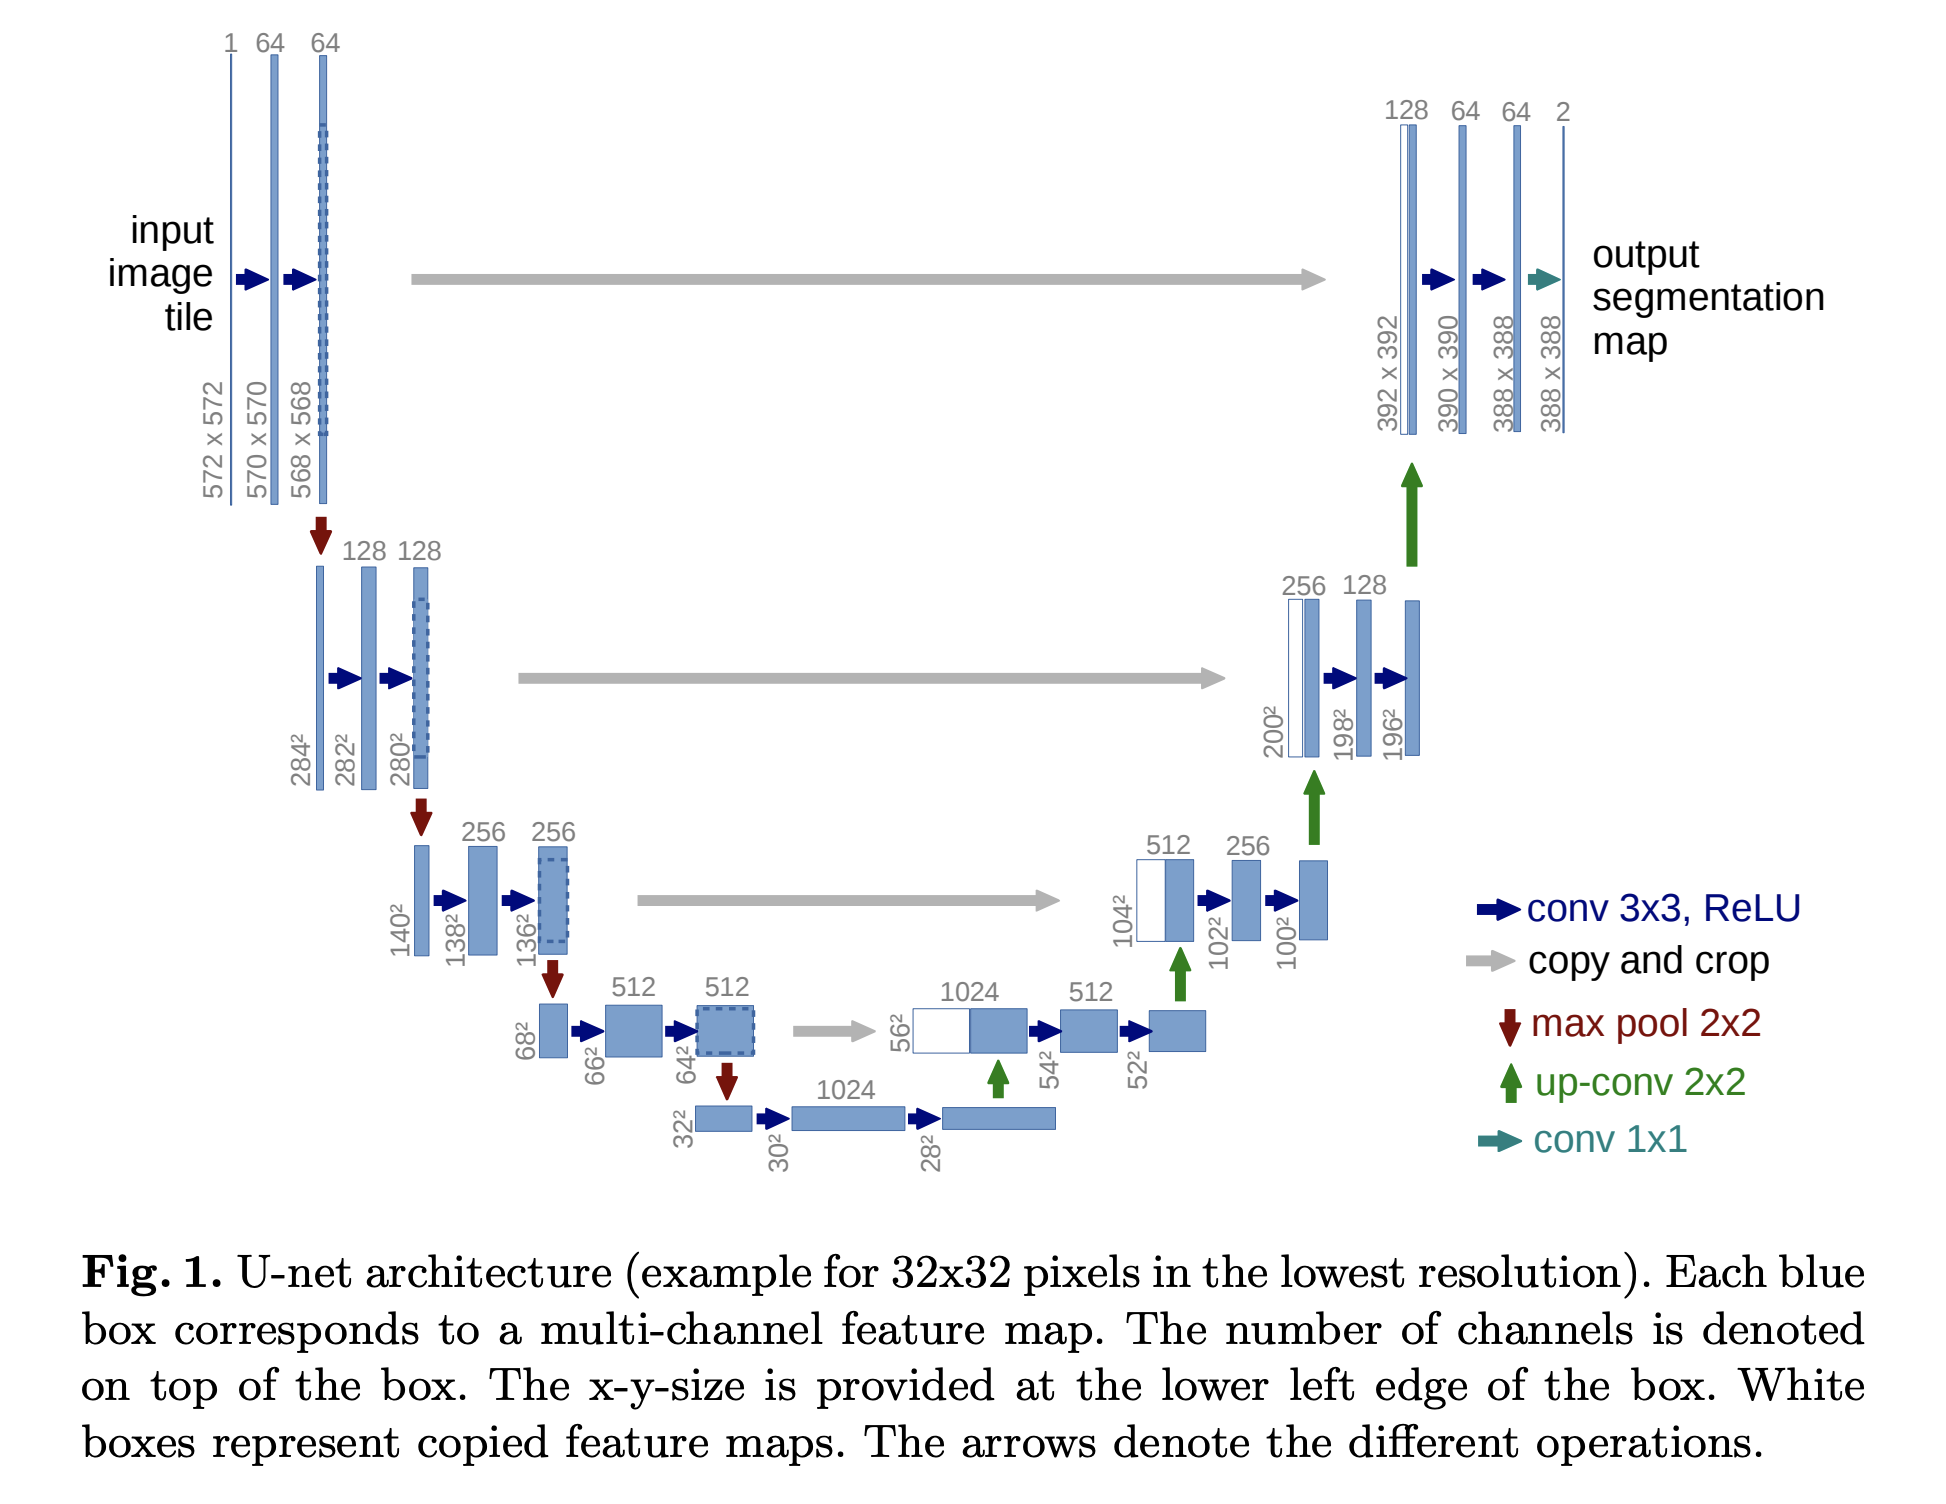

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [11]:
feature_extractor = vgg13(weights=VGG13_Weights.DEFAULT).features
feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=True)
  (17): Conv2d(512, 512, kernel_si

In [12]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        blocks_gen = VGG13Encoder.__blocks_extractor(vgg13(weights=weights).features)
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList([block for _, block in zip(range(num_blocks), blocks_gen)])

    @staticmethod
    def __blocks_extractor(fe):
        fe = iter(fe)
        while True:
            block = nn.Sequential(*(b for _, b in zip(range(4), fe)))
            yield block
            next(fe) # drop MaxPool2d
            

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            x = block(x)

            # Сохраните активации для передачи их в декодер
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
            
        return activations

In [13]:
VGG13Encoder(num_blocks=3)

VGG13Encoder(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
)

In [14]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

print("\n".join(f"{idx=}\tactivation={torch.linalg.norm(act).item():.4f}" for idx, act in enumerate(out)))

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

idx=0	activation=902.2188
idx=1	activation=571.0300
idx=2	activation=648.0689


#### `Decoder`

In [15]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=out_channels * 2, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=3, padding=1, dilation=1
            ),
            torch.nn.ReLU(),
        )
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # print(f"{down.shape=}\t{left.shape=}",end="\t")
        
        x = self.upconv(F.interpolate(down, scale_factor=2))
        # print(f"{x.shape=}")
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat([x, left], dim=1)
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv_block(x)

        return x

In [16]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [17]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        
        # your code here
        self.decoder = Decoder(num_blocks=num_blocks-1, num_filters=64)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)

        return x

In [18]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [19]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None, with_logits: bool = False):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        self.with_logits = with_logits
        
    @torch.no_grad()
    def forward(self, logits, true_labels, reduction=None):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        reduction = reduction if reduction is not None else self.reduction
        if self.with_logits:
            logits = F.sigmoid(logits)
        
        logits = torch.where(logits > self.threshold, 1.0, 0.0)
        
        prod_sum = torch.sum(logits * true_labels, dim=[-2, -1])
        score = prod_sum / (torch.sum(true_labels, dim=[-2, -1]) + torch.sum(logits, dim=[-2, -1]) - prod_sum)
        
        if reduction == 'sum':
            score = torch.sum(score)
        elif reduction == 'mean':
            score = torch.mean(score)
            
        return score

In [20]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [21]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

device

device(type='cuda', index=0)

In [22]:
from itertools import count

In [23]:
def train_epoch(
    network,
    train_loader,
    criterion,
    metric,
    optimizer,
    writer: SummaryWriter,
    logging_interval: int = 1,
    logger_step_cntr: count = None,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    logger_step_cntr = count() if logger_step_cntr is None else logger_step_cntr
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        logger_step = next(logger_step_cntr)
        
        if logger_step % logging_interval == 0:
            mt = metric(logits, masks).item()
            ls = loss.item()
            
            writer.add_scalar('Loss/train', ls, logger_step // logging_interval)
            writer.add_scalar('IoU/train', mt, logger_step // logging_interval)
            
            print(
                f'\tTest set at batch {logger_step:6}: '
                f'Avg. loss: {ls:.4f}',
                f'IoU: {mt}',
            )

In [24]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
    metric,
    writer: SummaryWriter,
    epoch_no: int
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    val_metric = 0

    network.eval()  # switch network submodules to test mode
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        logits = network(images)
        # print(f"crt: {criterion(logits, masks).item():.8f}")
        val_loss += criterion(logits, masks).item()        
        val_metric += metric(logits, masks).item()

    val_loss /= len(val_loader.dataset)
    val_metric /= len(val_loader.dataset)

    writer.add_scalar('Loss/val', val_loss, epoch_no)
    writer.add_scalar('IoU/val', val_metric, epoch_no)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'IoU: {val_metric}',
    )
    
    return val_loss, val_metric

In [27]:
def train_val(
    network,
    n_epochs,
    train_criterion,
    train_metric,
    val_criterion,
    val_metric,
    optimizer,
    lr_scheduler,
    train_loader,
    val_loader,
    writer: SummaryWriter,
    logging_interval: int = 5,
    best_dump_path: str = None,
    metric_dump_threshold: float = 0.0,
):
    """full cycle of neural network training"""

    logger_step_cntr = count(0)
    current_val_loss, current_val_metric = val_epoch(network, val_loader, val_criterion, val_metric, writer, epoch_no=0)
    
    best_val_loss = current_val_loss
    best_val_metric = current_val_metric
    
    for epoch in range(1, n_epochs + 1):
        writer.add_scalar('Params/LR', optimizer.state_dict()['param_groups'][0]['lr'], epoch)
        train_epoch(network, train_loader, train_criterion, train_metric, optimizer, writer, logging_interval, logger_step_cntr)
        current_val_loss, current_val_metric = val_epoch(network, val_loader, val_criterion, val_metric, writer, epoch_no=epoch)
        lr_scheduler.step(current_val_loss)
        writer.flush()
        
        if (current_val_metric > best_val_metric) and (best_dump_path is not None) and (current_val_metric > metric_dump_threshold):
            best_val_metric = current_val_metric
            with open(best_dump_path, "wb") as f:
                torch.save(
                    obj=(model.state_dict(), optimizer.state_dict(), current_val_loss, current_val_metric),
                    f=f
                )

In [28]:
DATA_PATH = pathlib.Path('people_data')

train_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('train'),
    target_dir=DATA_PATH.joinpath('train_mask'),
    transforms=[transforms.ToTensor()]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH.joinpath('test'),
    target_dir=DATA_PATH.joinpath('test_mask'),
    transforms=[transforms.ToTensor()]
)

test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=0)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

In [29]:
torch.cuda.empty_cache()

model = UNet(num_blocks=3, num_classes=1).to(device)

writer = SummaryWriter("TestUNet")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, min_lr=1e-6)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

train_val(
    network=model,
    train_criterion=nn.BCEWithLogitsLoss(reduction='mean'),
    train_metric=IoUScore(0.0, reduction='mean'),
    val_criterion=nn.BCEWithLogitsLoss(reduction='sum'),
    val_metric=IoUScore(0.0, reduction='sum'),
    optimizer=optimizer,
    train_loader=train_data_loader,
    val_loader=test_data_loader,
    n_epochs=50,
    writer=writer,
    lr_scheduler=lr_scheduler,
    logging_interval=10,
    best_dump_path='test_UNet_best.bin',
    metric_dump_threshold=0.8,
)

Test set: Avg. loss: 54514.6622 IoU: 0.002374503787950421
	Test set at batch      0: Avg. loss: 0.6984 IoU: 0.0028057845775038004
	Test set at batch     10: Avg. loss: 0.6924 IoU: 0.5804331302642822
	Test set at batch     20: Avg. loss: 0.5707 IoU: 0.7289762496948242
	Test set at batch     30: Avg. loss: 0.5643 IoU: 0.6095116138458252
	Test set at batch     40: Avg. loss: 0.4575 IoU: 0.7715713977813721
	Test set at batch     50: Avg. loss: 0.5901 IoU: 0.6582203507423401
	Test set at batch     60: Avg. loss: 0.5550 IoU: 0.6333960294723511
	Test set at batch     70: Avg. loss: 0.5241 IoU: 0.6552459001541138
	Test set at batch     80: Avg. loss: 0.4373 IoU: 0.7285542488098145
	Test set at batch     90: Avg. loss: 0.4588 IoU: 0.722392737865448
	Test set at batch    100: Avg. loss: 0.5159 IoU: 0.6064859628677368
	Test set at batch    110: Avg. loss: 0.4197 IoU: 0.742550253868103
	Test set at batch    120: Avg. loss: 0.4086 IoU: 0.8131372928619385
	Test set at batch    130: Avg. loss: 0.5376

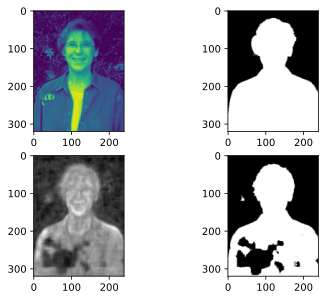

In [30]:
_, ax = plt.subplots(ncols=2, nrows=2)
model.cpu()

img, mask = test_dataset[0]
ax[0, 0].imshow(img[0, :, :].numpy())
ax[0, 1].imshow(mask[0, :, :].numpy(), cmap='gray')

ax[1, 0].imshow(model(img[None, :, :, :])[0, 0, :, :].detach().numpy(), cmap='gray')
ax[1, 1].imshow(model(img[None, :, :, :])[0, 0, :, :].detach().numpy() > 0.5, cmap='gray')

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [ ]:
# your code here

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```